While going through our script we will gradually understand the use of this packages

# 紐約時報評論分析

### 預期分析方向

1. 預測評論點贊數: commentBody, recommendations, sectionName, newDesk, userLocation。
2. 預測編輯選擇的評論: commentBody, editorsSelection, sectionName, newDesk。
3. 根據評論猜測文章主題: commentBody, sectionName, newDesk。
4. 預測評論獲得回覆的可能性: commentBody, replyCount, sectionName, userLocation。
5. 預測文章引發討論的可能性: articleID, articleWordCount, sectionName, newDesk, commentBody, replyCount, recommendations。
6. 對評論文本進行情感分析: commentBody。

In [1]:
# data preprocess tool 
import tensorflow as tf #no need to describe ;)
import numpy as np #allows array operation
import pandas as pd #we will use it to read and manipulate files and columns content
import re

# NLP 
import nltk
from nltk.corpus import stopwords #provides list of english stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop = stopwords.words('english')

# 下載NLTK資源（如果尚未下載）
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

## utils
from collections import Counter
import opencc
import warnings

# 忽略所有警告
warnings.filterwarnings('ignore')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xdxd2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xdxd2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xdxd2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#PRINT VERSION!!
tf.__version__

'2.14.0'

To do this notebook we will use New York Times user comments (from Kaggle Datasets).
When we will create the language classifier we will use other data but now let's rely on an english natural language source, so now we read the data.


[資料連結](https://www.kaggle.com/datasets/aashita/nyt-comments/data)




## 資料準備

In [3]:
#PLEASE DOWNLOAD THE FILE HERE: https://www.kaggle.com/aashita/nyt-comments
train = pd.read_csv('./CommentsApril2017/CommentsApril2017.csv')


Let's have a quick look at the data trying to find what is the column that we need.
Looks like commentBody is the right candidate.

In [4]:
train.head()


,approveDate,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,parentID,...,userLocation,userTitle,userURL,inReplyTo,articleID,sectionName,newDesk,articleWordCount,printPage,typeOfMaterial
0,1491245186,This project makes me happy to be a 30+ year T...,22022598.0,22022598,<br/>,comment,1.491237e+09,1,False,0.0,...,"Riverside, CA",NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News
1,1491188619,Stunning photos and reportage. Infuriating tha...,22017350.0,22017350,NaN,comment,1.491180e+09,1,False,0.0,...,<br/>,NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News
2,1491188617,Brilliant work from conception to execution. I...,22017334.0,22017334,<br/>,comment,1.491179e+09,1,False,0.0,...,Raleigh NC,NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News
3,1491167820,NYT reporters should provide a contributor's l...,22015913.0,22015913,<br/>,comment,1.491150e+09,1,False,0.0,...,"Missouri, USA",NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News
4,1491167815,Could only have been done in print. Stunning.,22015466.0,22015466,<br/>,comment,1.491147e+09,1,False,0.0,...,"Tucson, Arizona",NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News


### 元數據描述

| 字段名稱                   | 數據型態        | 說明                         |
|-------------------------|--------------|----------------------------|
| approveDate             | int64        | 評論獲得審核的日期和時間           |
| commentBody             | 文本型態        | 包含評論的完整內容               |
| commentID               | float64      | 評論的唯一識別碼                 |
| commentSequence         | int64        | 評論的序列號                   |
| commentTitle            | 文本型態        | 評論的標題                     |
| commentType             | 文本型態        | 評論的類型                     |
| createDate              | float64      | 評論的創建日期和時間             |
| depth                   | int64        | 評論在對話結構中的深度            |
| editorsSelection        | bool         | 是否被編輯選為特色評論             |
| parentID                | float64      | 該評論回覆的父評論ID             |
| parentUserDisplayName   | 文本型態        | 父評論的用戶顯示名稱              |
| permID                  | 文本型態        | 評論的永久識別碼                |
| picURL                  | 文本型態        | 評論中包含的圖片網址              |
| recommendations         | float64      | 評論獲得的推薦數量               |
| recommendedFlag         | 數據不可用      | -                           |
| replyCount              | float64      | 該評論獲得的回覆數量              |
| reportAbuseFlag         | 數據不可用      | -                           |
| sharing                 | int64        | 評論被分享的次數                 |
| status                  | 文本型態        | 評論的狀態（例如：已發布、審核中等） |
| timespeople             | float64      | 特定用戶群的相關數據              |
| trusted                 | float64      | 評論的可信程度                  |
| updateDate              | int64        | 評論最後的更新日期和時間            |
| userDisplayName         | 文本型態        | 用戶的顯示名稱                  |
| userID                  | int64        | 用戶的唯一識別碼                 |
| userLocation            | 文本型態        | 用戶的地理位置                  |
| userTitle               | 數據幾乎不可用    | -                           |
| userURL                 | 數據幾乎不可用    | -                           |
| inReplyTo               | int64        | 評論是回覆給哪個評論/文章的ID      |
| articleID               | 文本型態        | 文章的唯一識別碼                |
| sectionName             | 文本型態        | 文章所屬的版塊                  |
| newDesk                 | 文本型態        | 文章所屬的新聞台                |
| articleWordCount        | float64      | 文章的總字數                   |
| printPage               | int64        | 文章在報紙上的印刷頁碼             |
| typeOfMaterial          | 文本型態        | 文章的類型（例如：新聞、評論等）   |


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243832 entries, 0 to 243831
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   approveDate            243832 non-null  int64  
 1   commentBody            243832 non-null  object 
 2   commentID              243832 non-null  float64
 3   commentSequence        243832 non-null  int64  
 4   commentTitle           228498 non-null  object 
 5   commentType            243832 non-null  object 
 6   createDate             243832 non-null  float64
 7   depth                  243832 non-null  int64  
 8   editorsSelection       243832 non-null  bool   
 9   parentID               243832 non-null  float64
 10  parentUserDisplayName  70526 non-null   object 
 11  permID                 243832 non-null  object 
 12  picURL                 243832 non-null  object 
 13  recommendations        243832 non-null  float64
 14  recommendedFlag        0 non-null   

## 資料預處理


1. 文本清理：移除特殊符號、數字、不必要的空格等。
2. 轉換為小寫：統一文本格式，方便處理。
3. 去除停用詞：停用詞（如 "the", "is", "in" 等）對於文本分析(敘述性統計)任務來說，停頓詞非必要性。
4. 詞幹提取或詞形還原：將單詞還原到基本形式，例如，將 "running" 轉換為 "run"。
5. 分詞：將句子分割成單獨的單詞或詞彙。

In [10]:
from multiprocessing import Pool
import string

# Load NLTK resources once
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text preprocessing function optimized
def preprocess_text(text):
    # Remove special characters and punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Convert to lowercase
    text = text.lower()

    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop]
    
    return ' '.join(tokens)

# Function to process a batch of texts
def process_batch(texts):
    return [preprocess_text(text) for text in texts]

# Use parallel processing to preprocess the texts
def parallel_preprocessing(df, column_name):
    num_cores = 4  # Adjust this according to your machine's capability
    batch_size = int(len(df) / num_cores)
    batches = [df[i:i + batch_size] for i in range(0, df.shape[0], batch_size)]
    
    with Pool(num_cores) as pool:
        result = pool.map(process_batch, [batch[column_name].tolist() for batch in batches])
    
    # Flatten the list of results
    return [item for sublist in result for item in sublist]


# Apply parallel preprocessing
train['commentBody_cln'] = parallel_preprocessing(train, 'commentBody')

train.head()



In [7]:
import string

In [8]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
train['commentBody']

0         This project makes me happy to be a 30+ year T...
1         Stunning photos and reportage. Infuriating tha...
2         Brilliant work from conception to execution. I...
3         NYT reporters should provide a contributor's l...
4            Could only have been done in print. Stunning. 
                                ...                        
243827    Sorry, but pudding has nothing to do with it; ...
243828    While it would be quite punny to spell it "des...
243829         See above comments. "deserts" is the proper.
243830    John Rubinstein had two brief scenes with Joan...
243831    Ye gods and little fishes, Stu, you're right ....
Name: commentBody, Length: 243832, dtype: object

In [74]:
train['commentBody_lower'] = train["commentBody"].str.lower()
train['commentBody_no_punctiation'] = train['commentBody_lower'].str.replace('[^\w\s]','')

let's check how the text looks like now!
Well everything is lowercase and no "ugly characters"

In [75]:
train['commentBody_no_punctiation']

0         this project makes me happy to be a 30+ year t...
1         stunning photos and reportage. infuriating tha...
2         brilliant work from conception to execution. i...
3         nyt reporters should provide a contributor's l...
4            could only have been done in print. stunning. 
                                ...                        
243827    sorry, but pudding has nothing to do with it; ...
243828    while it would be quite punny to spell it "des...
243829         see above comments. "deserts" is the proper.
243830    john rubinstein had two brief scenes with joan...
243831    ye gods and little fishes, stu, you're right ....
Name: commentBody_no_punctiation, Length: 243832, dtype: object

Now we remove stopwords and then fill empy cells with "fillna" word.

In [76]:
train['commentBody'][0]

'This project makes me happy to be a 30+ year Times subscriber... continue to innovate across all platforms, please.'

In [77]:
train['commentBody_no_punctiation'][0]

'this project makes me happy to be a 30+ year times subscriber... continue to innovate across all platforms, please.'

In [78]:
train['commentBody_no_stopwords'] = train['commentBody_no_punctiation'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [79]:
train["commentBody_no_stopwords"] = train["commentBody_no_stopwords"].fillna("no comment")


This is how our cleaned text looks like we can see that everything is lowercase and the stopwords are missing, for example "this". Now let's go back to slides.


In [80]:
train['commentBody_no_stopwords'].head()

0    project makes happy 30+ year times subscriber....
1    stunning photos reportage. infuriating trump a...
2    brilliant work conception execution. i've neve...
3    nyt reporters provide contributor's link crowd...
4                          could done print. stunning.
Name: commentBody_no_stopwords, dtype: object

In [81]:
tf_train = train


We first assign our current data frame to another to keep track of our work then we read the first sentence and count words that result to be 21

### check commentBody length

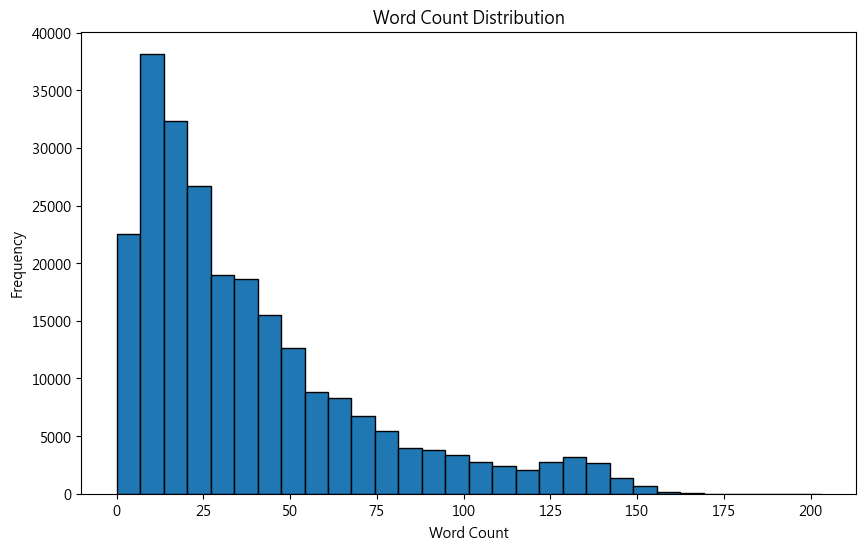

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming tf_train['commentBody_no_stopwords'] is already defined
# Calculate word count for each row
word_counts = tf_train['commentBody_no_stopwords'].str.split().apply(len)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=30, edgecolor='black')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()



In [83]:
tf_train['commentBody_no_stopwords'][1]

"stunning photos reportage. infuriating trump admistration's draconian reinstatement global gag order prevent men women receiving appropriate family planning advice, obviously desperately needed."

In [84]:
tf_train['commentBody_no_stopwords'][1].count(' ')

21

## tokenize, sequence, padding

In [85]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [86]:
max_features = 5000  # maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(tf_train['commentBody_no_stopwords']))
sequences = tokenizer.texts_to_sequences(list(tf_train['commentBody_no_stopwords']))


In [87]:
maxlen = 100  # maximum length of all sequences
tok_seq = pad_sequences(sequences, maxlen=maxlen)


In [89]:
# padding sequence length 
len(tok_seq[1])

100

In [88]:
tok_seq[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0, 3542,    2,  582,
        387, 1416,  237,  100, 3504, 1822,  153, 1964, 1490,  928, 3228,
        464])

In [92]:
# Assuming tok_seq and decode 
index_word = tokenizer.index_word
decoded_sequence = ' '.join([index_word.get(i, '') for i in tok_seq[1]])
print(decoded_sequence)


                                                                                     photos trump global order prevent men women receiving appropriate family planning advice obviously desperately needed


In [93]:
list(tf_train['commentBody_no_stopwords'])[1]  #let's look at the input text

"stunning photos reportage. infuriating trump admistration's draconian reinstatement global gag order prevent men women receiving appropriate family planning advice, obviously desperately needed."

In [95]:
#let's look at the final matrix that will use as an input for our deep learning algorithms, do you remember 
#how original text looked like?

df_tok_seq = pd.DataFrame(tok_seq)
df_tok_seq


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,1914,220,638,722,129,83,316,754,288
1,0,0,0,0,0,0,0,0,0,0,...,237,100,3504,1822,153,1964,1490,928,3228,464
2,0,0,0,0,0,0,0,0,0,0,...,1895,473,165,606,2291,1333,2959,1439,2252,1237
3,0,0,0,0,0,0,0,0,0,0,...,4338,96,2875,2201,73,517,3747,940,1016,2982
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,18,154,2682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243827,0,0,0,0,0,0,0,0,0,0,...,0,0,614,63,9,5,2021,2980,441,222
243828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,509,2665,94,3776
243829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,26,477,2171
243830,0,0,0,0,0,0,0,0,0,0,...,466,1434,1967,891,158,1212,48,168,8,1393
